In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import intersect1d
from datetime import datetime

from ethereum import EthereumData

In [2]:
dt = "2021-09-01"

eth_data = EthereumData(start_date=dt, end_date=dt, save_path=f"data/{dt}")

In [3]:
eth_data.load()

Loading blocks...
Loading transactions...
Loading contracts...
Loading logs...
Loading receipts...
Loading token_transfers...
Loading tokens...


In [4]:
clean_tx = eth_data.clean()

In [7]:
clean_tx.columns

Index(['hash', 'block_number', 'transaction_index', 'from_address',
       'to_address', 'value', 'gas', 'gas_price', 'max_fee_per_gas',
       'max_priority_fee_per_gas', 'transaction_type', 'transaction_hash',
       'cumulative_gas_used', 'gas_used', 'contract_address', 'status',
       'effective_gas_price', 'token_address', 'from_address_transfer',
       'to_address_transfer', 'value_transfer', 'transaction_hash_transfer',
       'log_index', 'block_number_transfer', 'address', 'function_sighashes',
       'is_erc20', 'is_erc721', 'block_number_to_contract',
       'address_from_contract', 'function_sighashes_from_contract',
       'is_erc20_from_contract', 'is_erc721_from_contract',
       'block_number_from_contract', 'number', 'miner', 'difficulty',
       'total_difficulty', 'size', 'gas_limit', 'gas_used_block',
       'transaction_count', 'base_fee_per_gas', 'datetime'],
      dtype='object')

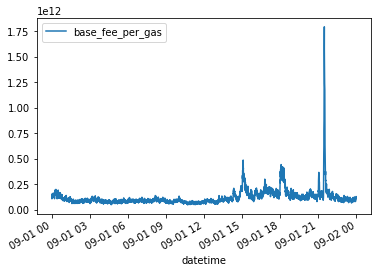

In [10]:
clean_tx[['datetime', 'base_fee_per_gas']].groupby('datetime').mean().plot()

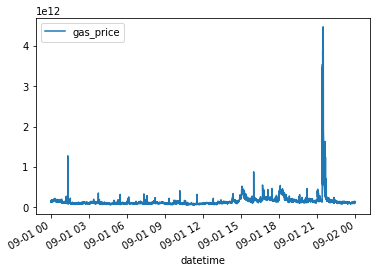

In [11]:
clean_tx[['datetime', 'gas_price']].groupby('datetime').mean().plot()

In [13]:
clean_tx.columns

Index(['hash', 'block_number', 'transaction_index', 'from_address',
       'to_address', 'value', 'gas', 'gas_price', 'max_fee_per_gas',
       'max_priority_fee_per_gas', 'transaction_type', 'transaction_hash',
       'cumulative_gas_used', 'gas_used', 'contract_address', 'status',
       'effective_gas_price', 'token_address', 'from_address_transfer',
       'to_address_transfer', 'value_transfer', 'transaction_hash_transfer',
       'log_index', 'block_number_transfer', 'address', 'function_sighashes',
       'is_erc20', 'is_erc721', 'block_number_to_contract',
       'address_from_contract', 'function_sighashes_from_contract',
       'is_erc20_from_contract', 'is_erc721_from_contract',
       'block_number_from_contract', 'number', 'miner', 'difficulty',
       'total_difficulty', 'size', 'gas_limit', 'gas_used_block',
       'transaction_count', 'base_fee_per_gas', 'datetime'],
      dtype='object')

In [ ]:
clean_tx[['datetime', 'gas_price']].groupby('datetime').mean().plot()